#**Hands-on Material - Women's Clothing E-Commerce Dataset**#

This is a Women’s Clothing E-Commerce dataset revolving around the reviews written by customers. Its nine supportive features offer a great environment to parse out the text through its multiple dimensions. Because this is real commercial data, it has been anonymized, and references to the company in the review text and body have been replaced with “retailer”.

In [74]:
!pip install bayesian-optimization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# import spacy

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from scipy.stats import zscore
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score


This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Rating**: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

In [41]:
file_path = '/content/Womens Clothing E-Commerce Reviews.csv'

# Read the file into a pandas DataFrame
df = pd.read_csv(file_path)
df.drop(df.columns[0], axis=1, inplace=True)

# Title column preprocessing
df['Title'] = df['Title'].dropna()
df['Title'] = df['Title'].fillna('Unknown')

# Review Text column preprocessing
df['Review Text'] = df['Review Text'].fillna('')

# Display the DataFrame
df.head()


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,Unknown,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,Unknown,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [42]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100

missing_values_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_values_percentage
})

missing_values_info[missing_values_info['Missing Values'] > 0]

,Missing Values,Percentage
Division Name,14,0.05961
Department Name,14,0.05961
Class Name,14,0.05961


In [43]:
# Filling missing values for categorical columns with the most common value
for column in ['Division Name', 'Department Name', 'Class Name']:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Filling missing values for text columns with placeholder text
df['Title'].fillna('No Title', inplace=True)
df['Review Text'].fillna('No Review', inplace=True)

# Checking if all missing values are handled
df.isnull().sum().sum()  # Should be 0 if all missing values are handled

# Display the DataFrame
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,Unknown,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,Unknown,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


 ## **Exploratory Data Analysis (EDA)** ##

### 1. Basic statistics

In [12]:
df.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


### 2. Visualization of distributions

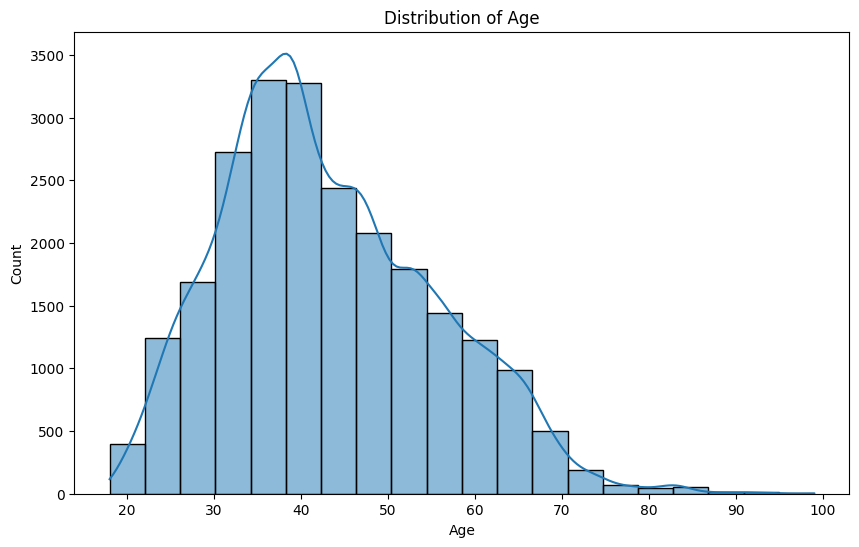

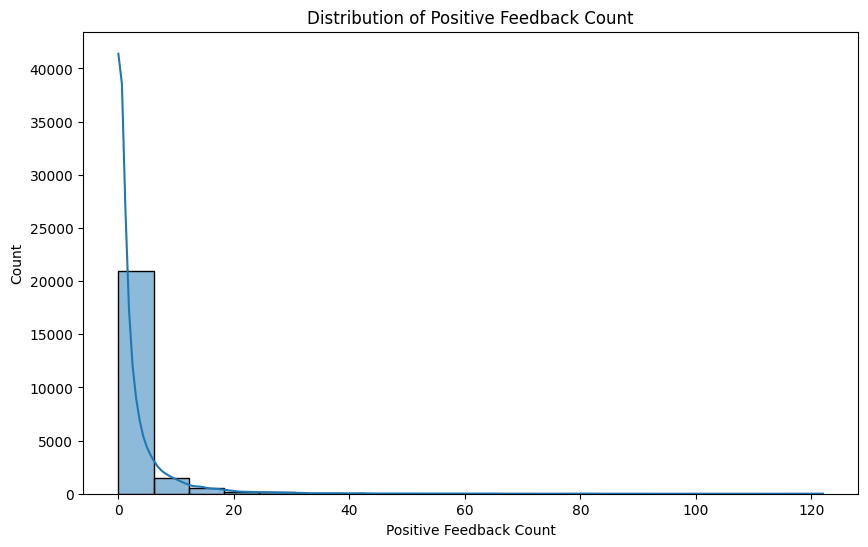

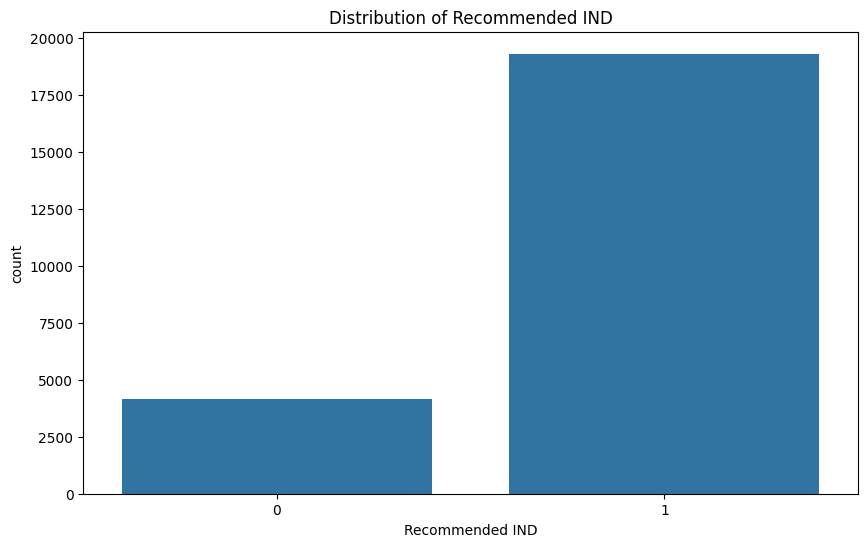

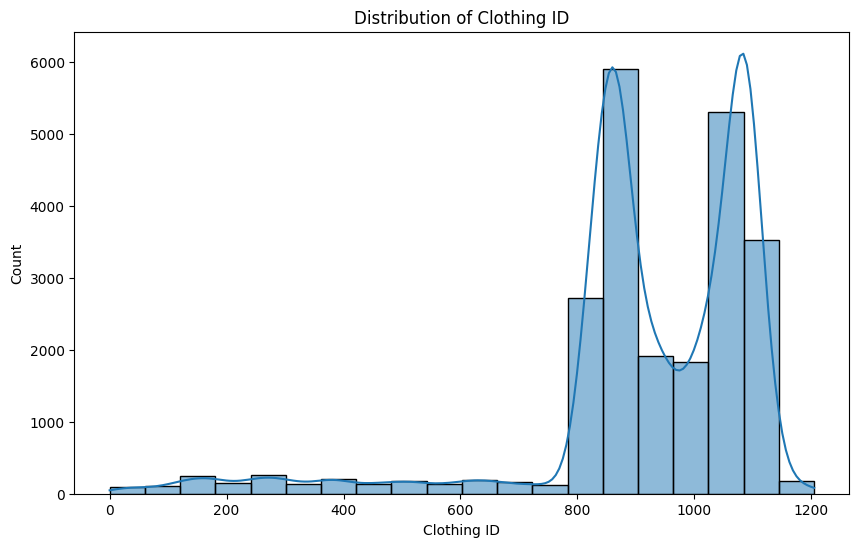

In [13]:
columns_of_interest = ['Age', 'Positive Feedback Count', 'Recommended IND', 'Clothing ID']

# Visualize distributions for each column of interest
for column in columns_of_interest:
    plt.figure(figsize=(10, 6))

    if column == 'Recommended IND':
        # For binary columns, use countplot
        sns.countplot(x=column, data=df)
        plt.title(f'Distribution of {column}')
    else:
        # For numerical columns, use histograms
        sns.histplot(df[column], bins=20, kde=True)
        plt.title(f'Distribution of {column}')

    plt.show()


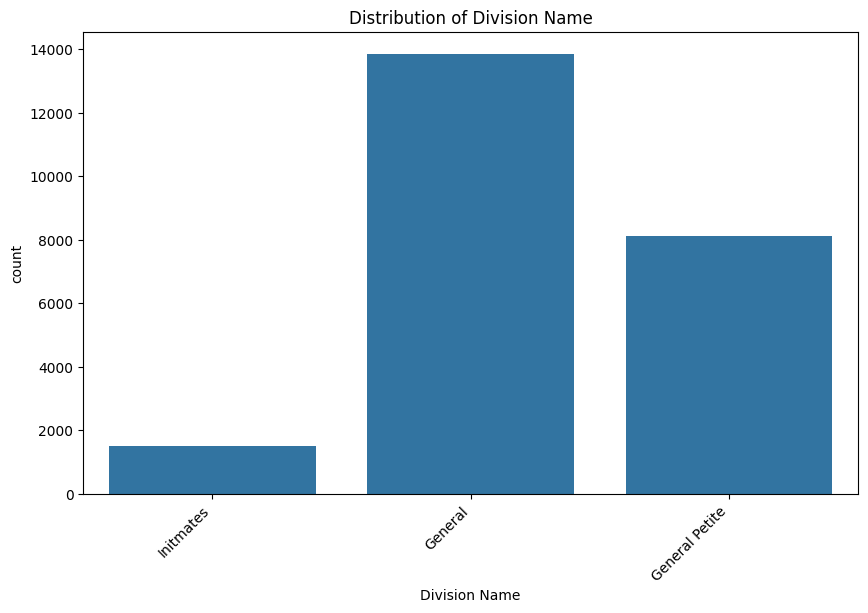

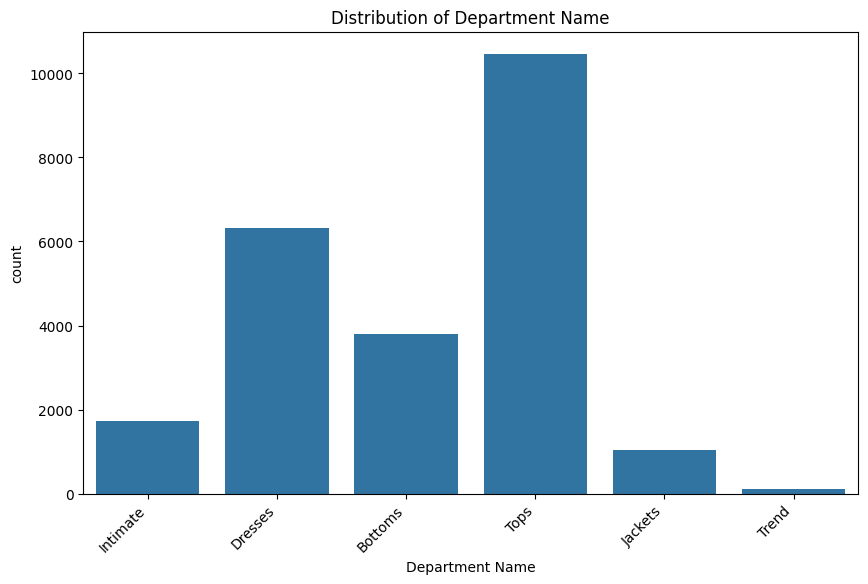

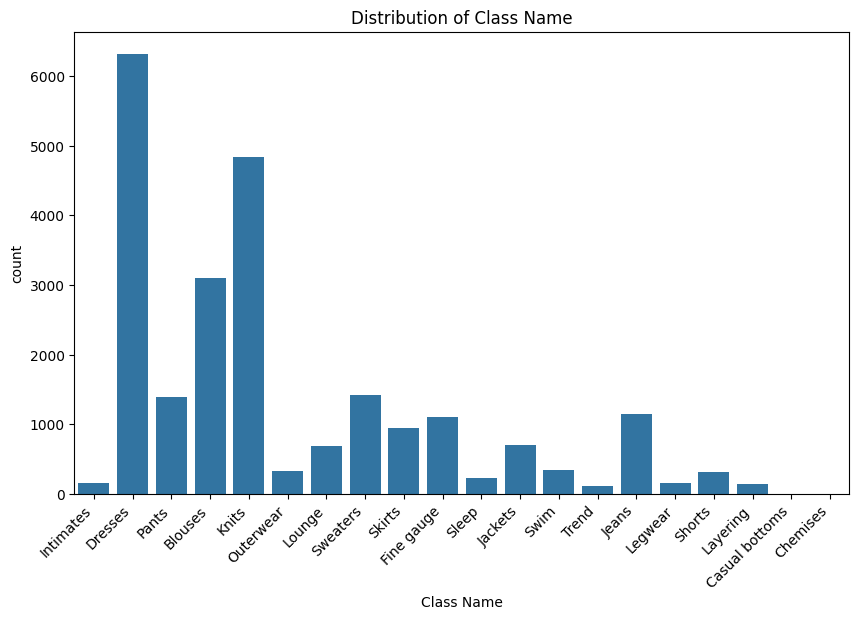

In [ ]:
# Categorical columns
categorical_columns = ['Division Name', 'Department Name', 'Class Name']

# Visualize distributions for each categorical column
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45, ha='right')
    plt.show()


### 3. Analysis of relationships and patterns

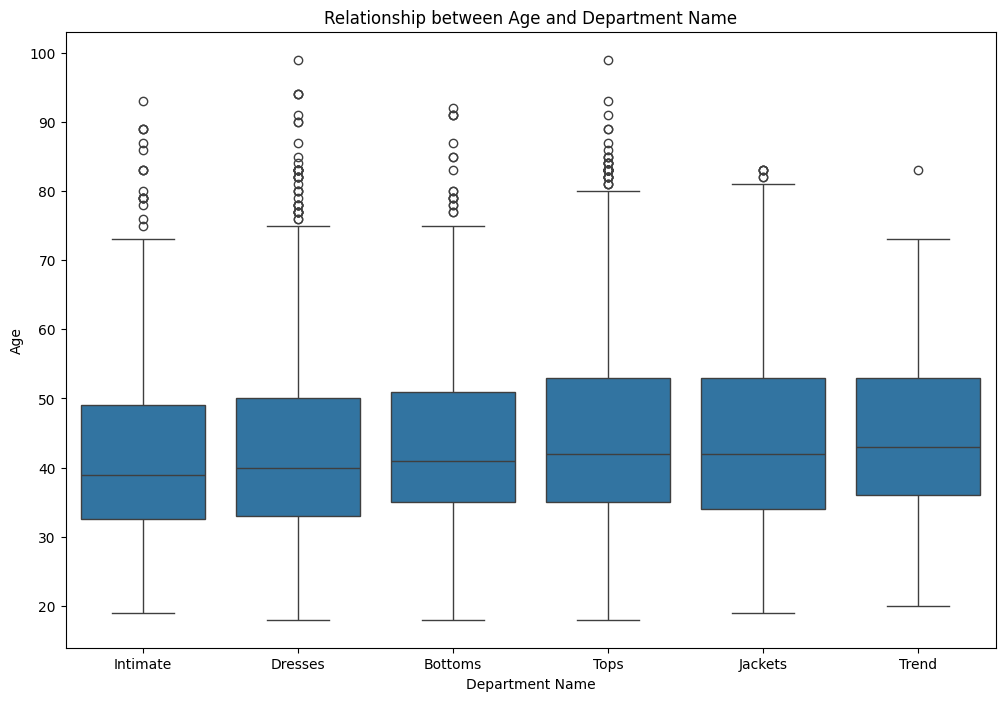

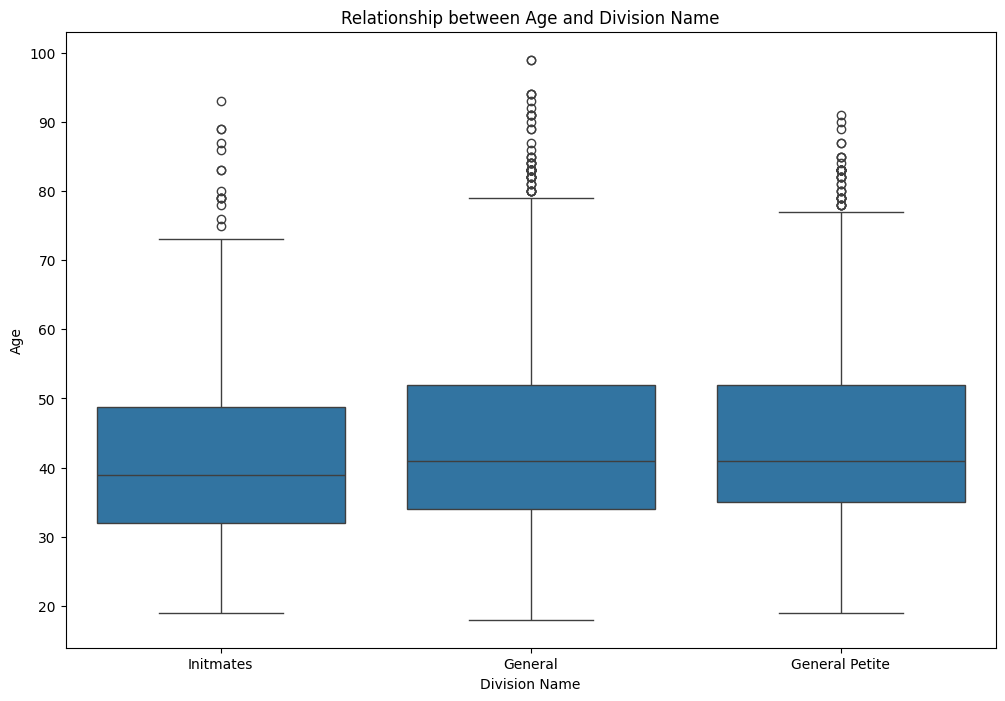

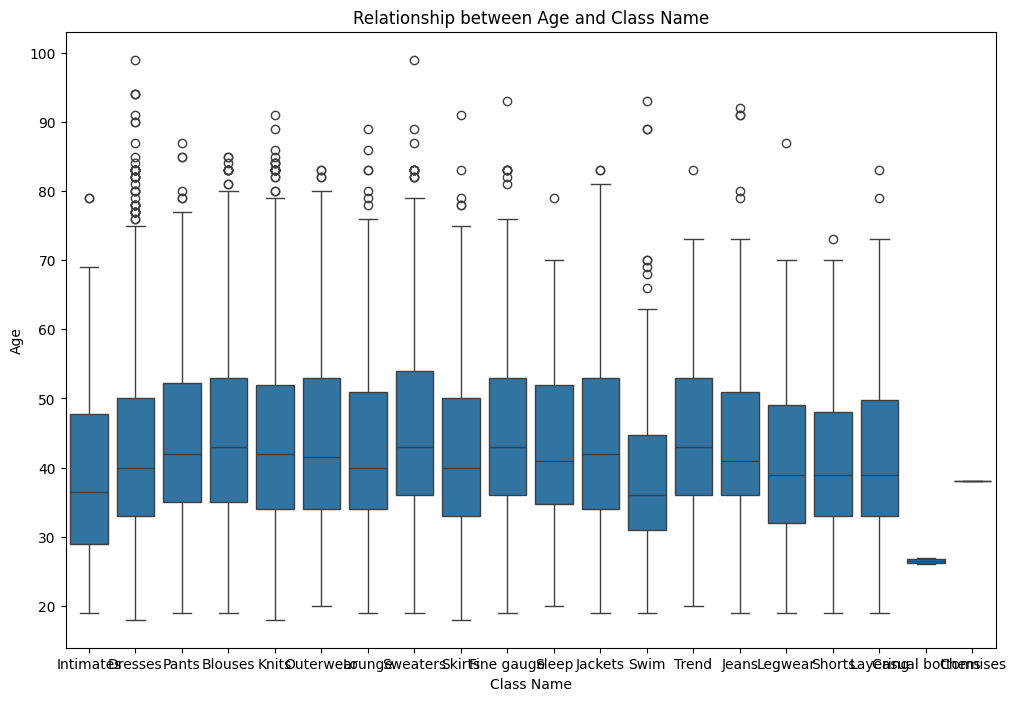

In [14]:
# Relationship between 'Age' and 'Department Name'
plt.figure(figsize=(12, 8))
sns.boxplot(x='Department Name', y='Age', data=df)
plt.title('Relationship between Age and Department Name')
plt.show()

# Relationship between 'Age' and 'Division Name'
plt.figure(figsize=(12, 8))
sns.boxplot(x='Division Name', y='Age', data=df)
plt.title('Relationship between Age and Division Name')
plt.show()

# Relationship between 'Age' and 'Class Name'
plt.figure(figsize=(12, 8))
sns.boxplot(x='Class Name', y='Age', data=df)
plt.title('Relationship between Age and Class Name')
plt.show()

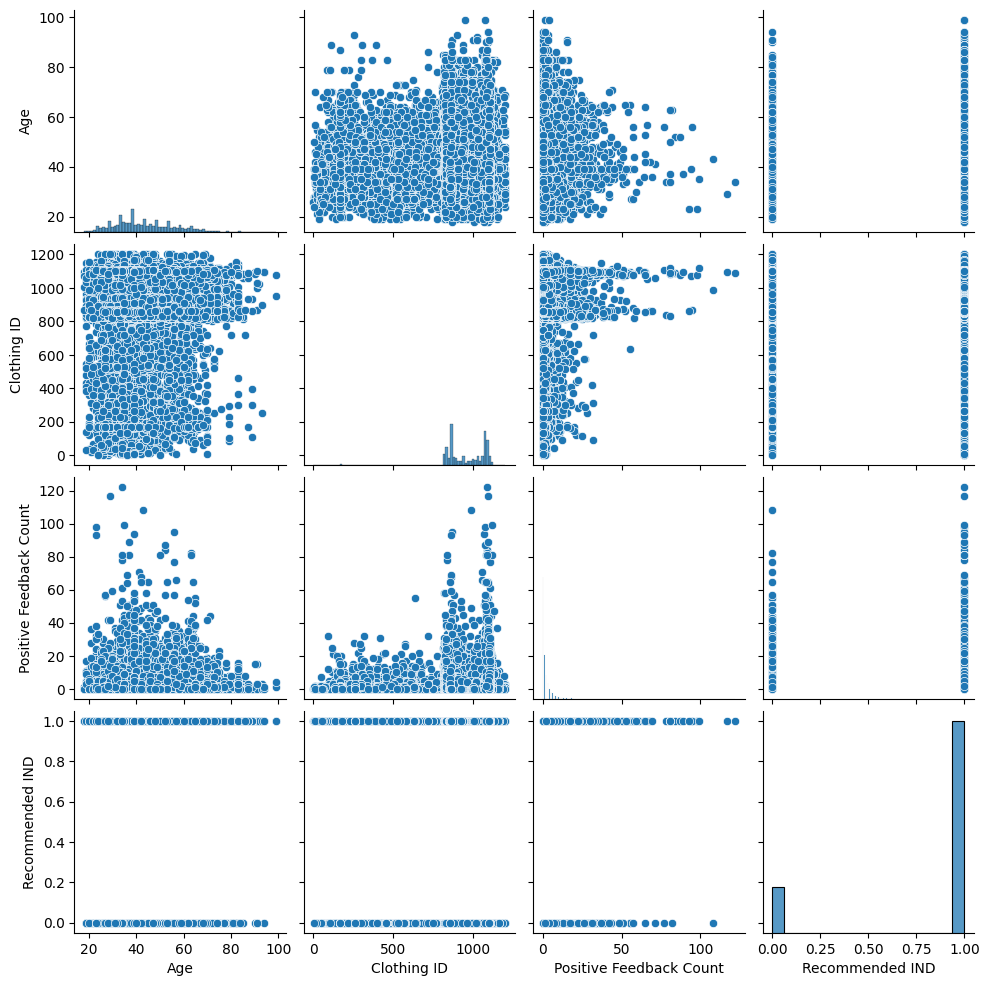

In [15]:
# Pairwise Relationships
sns.pairplot(df[['Age', 'Clothing ID', 'Positive Feedback Count', 'Recommended IND']])
plt.show()


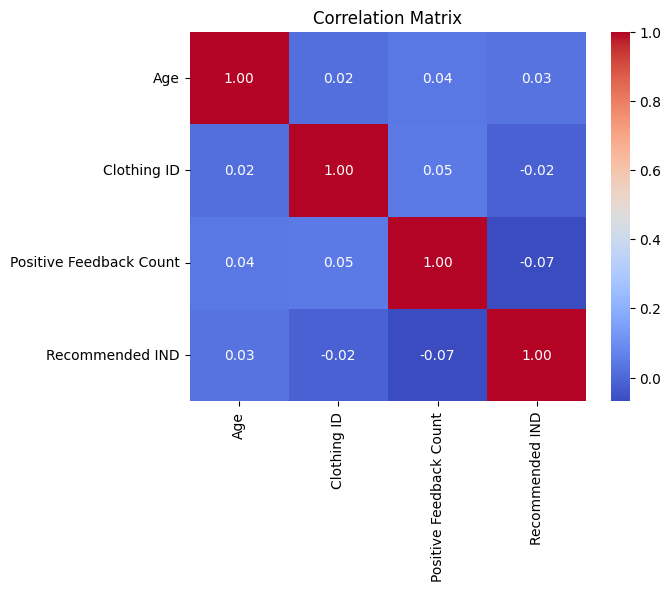

In [16]:
# Correlation Matrix
correlation_matrix = df[['Age', 'Clothing ID', 'Positive Feedback Count', 'Recommended IND']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


### 4. Handling Outliers

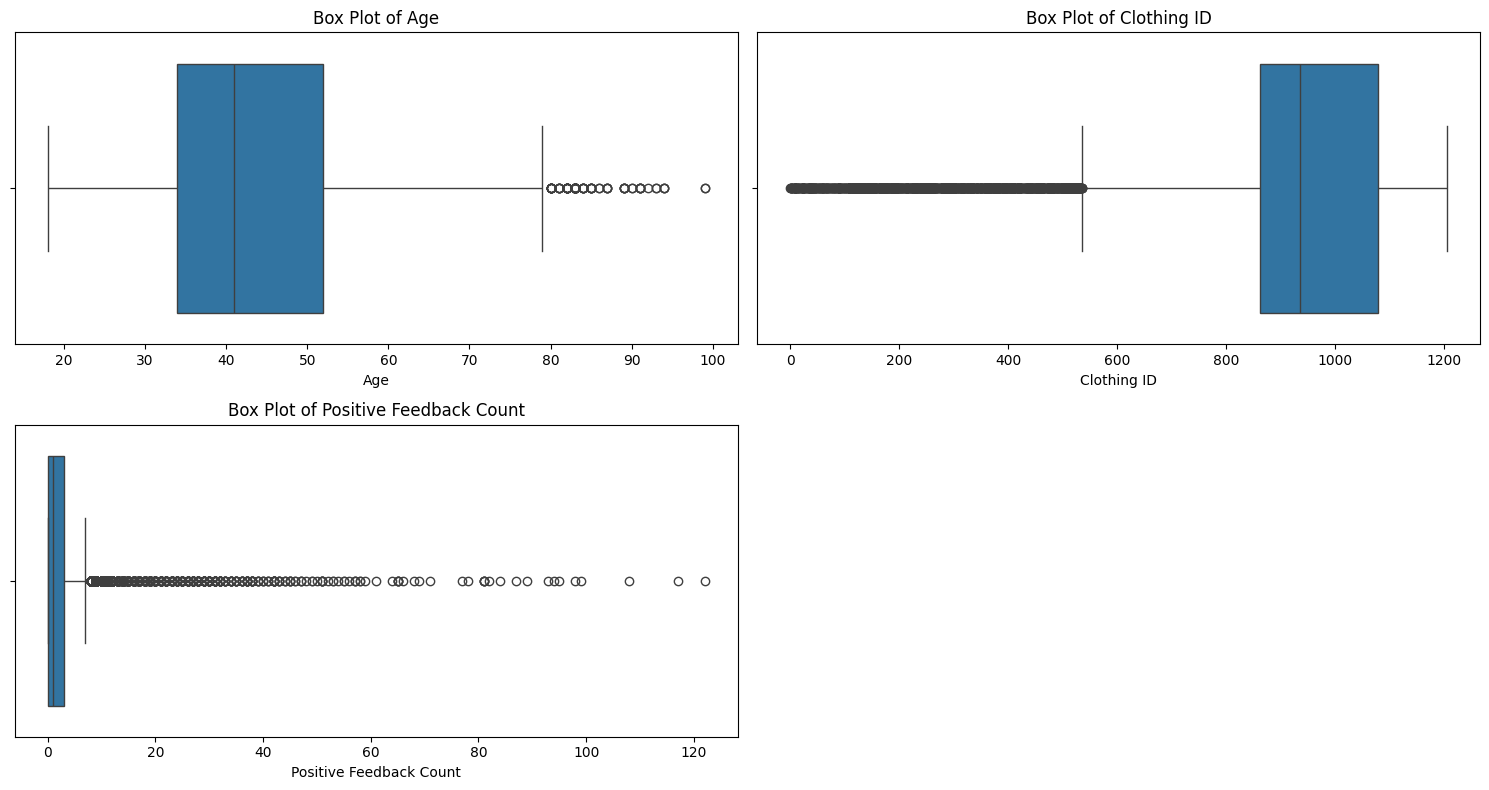

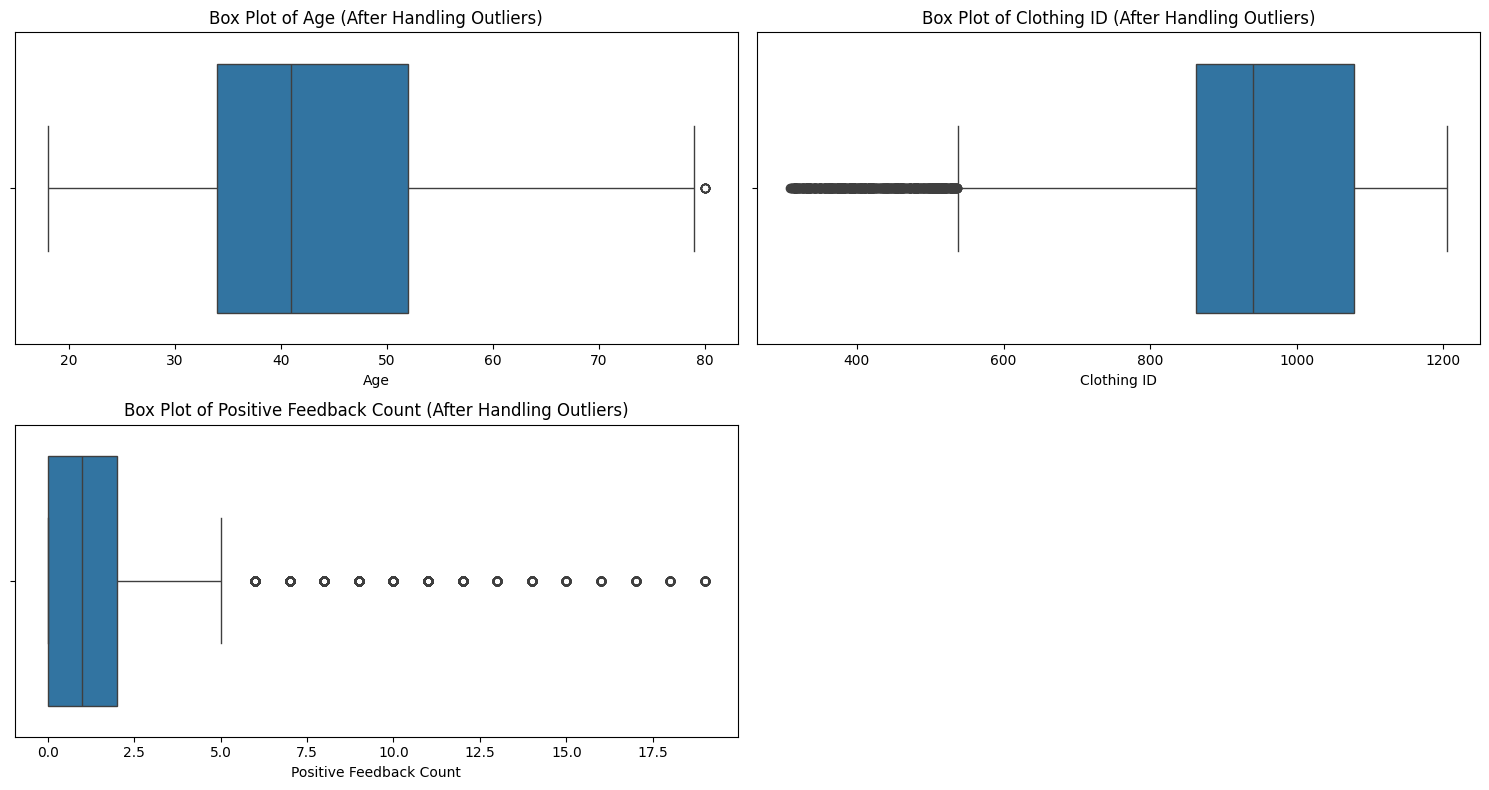

In [17]:
# Numerical columns
numerical_columns = ['Age', 'Clothing ID', 'Positive Feedback Count']

# Visualize box plots for numerical columns
plt.figure(figsize=(15, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()

# Identify and handle outliers
for column in numerical_columns:
    # Calculate z-scores for each numerical column
    z_scores = zscore(df[column])

    # Set a threshold for considering values as outliers (e.g., beyond 3 standard deviations)
    threshold = 3

    # Identify and handle outliers (remove or transform)
    df = df[(np.abs(z_scores) < threshold)]

# Visualize box plots after handling outliers
plt.figure(figsize=(15, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column} (After Handling Outliers)')

plt.tight_layout()
plt.show()


### 5. Text data analysis

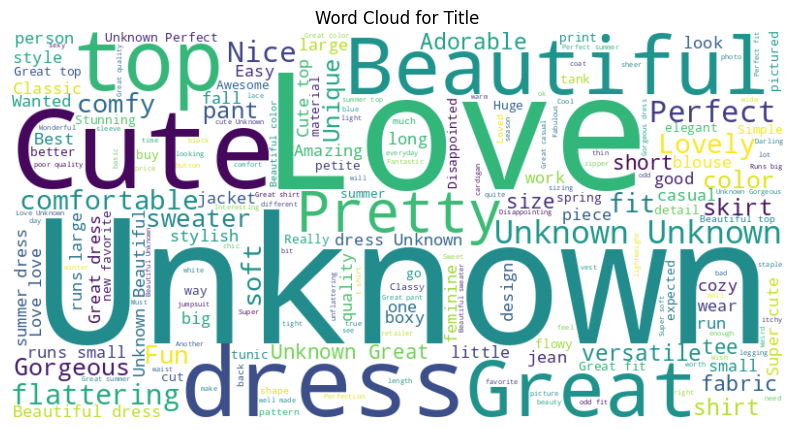

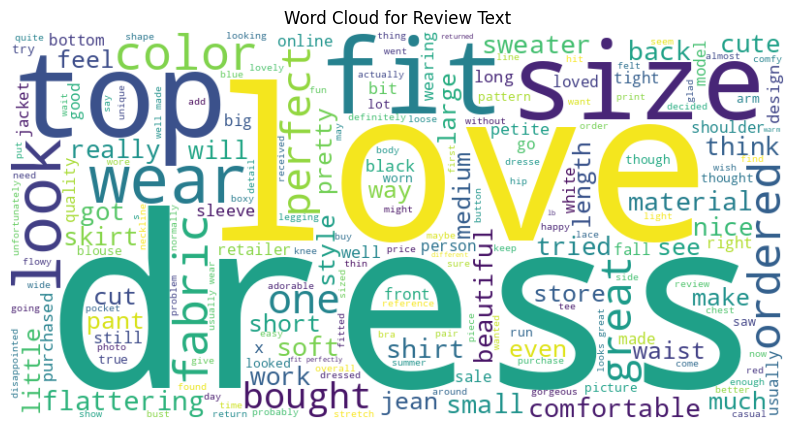

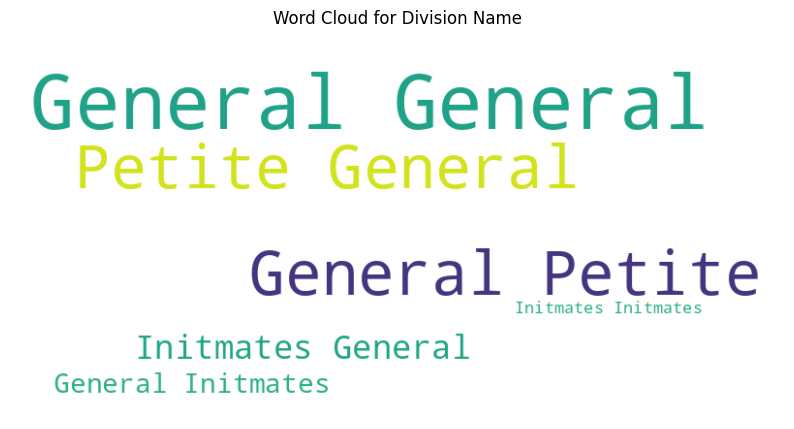

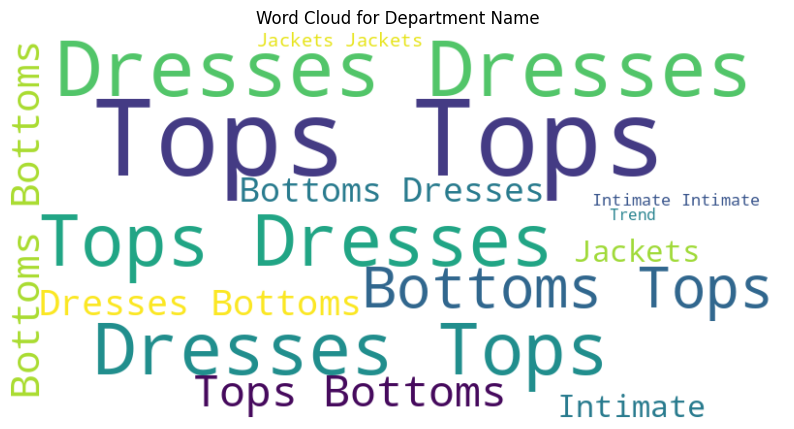

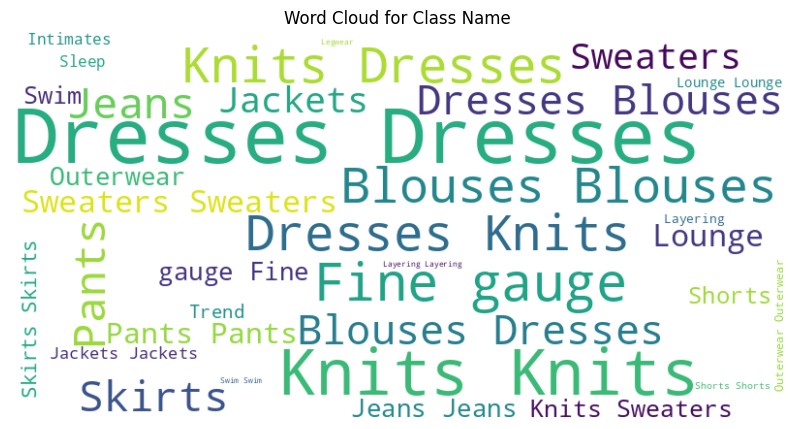

In [18]:
# List of columns to analyze (including categorical columns)
columns_to_analyze = ['Title', 'Review Text', 'Division Name', 'Department Name', 'Class Name']

# Text Data Analysis for all relevant columns
for column in columns_to_analyze:
    if column in ['Division Name', 'Department Name', 'Class Name']:
        # For categorical columns, concatenate all values into a single string
        text = ' '.join(df[column].astype(str).values)
    else:
        # For text columns, concatenate all non-null values into a single string
        text = ' '.join(df[column].dropna().astype(str).values)

    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column}')
    plt.show()



## **Encoding and Feature Scaling** ##

### **1. Encoding** ###

1. **Title:**

In [50]:
# Downloading necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set of English stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Tokenization
    words = word_tokenize(text)
    # Removing stop words
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

# Applying the preprocessing function to the Review Text column
df['Processed Title'] = df['Title'].apply(preprocess_text)

# Displaying the first few rows of the updated dataframe
df[['Title', 'Processed Title']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Title,Processed Title
0,Unknown,unknown
1,Unknown,unknown
2,Some major design flaws,major design flaws
3,My favorite buy!,favorite buy !
4,Flattering shirt,flattering shirt


In [ ]:
# TF-IDF Encoding:

# Check if the 'Title' column contains any np.nan values
if np.any(df['Title'].isna()):

    # Remove the np.nan values from the 'Title' column
    df = df.dropna(subset=['Title'])

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'Title' column
title_tfidf_matrix = tfidf_vectorizer.fit_transform(df['Title'])

# Check if any features were extracted
if title_tfidf_matrix.shape[1] > 0:
    # Convert the TF-IDF matrix to a DataFrame
    title_tfidf_df = pd.DataFrame(title_tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    # Concatenate the TF-IDF-encoded features with the original DataFrame
    df = pd.concat([df, title_tfidf_df], axis=1)

# Display the DataFrame
df.head()

In [ ]:
# Word Embeddings Encoding (using spaCy):

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Define a function to get the average word vector for a document
def get_avg_word_vector(doc):
    return np.mean([word.vector for word in doc if word.has_vector], axis=0)

# Apply spaCy's NLP pipeline to the 'Title' column
title_embeddings = df['Title'].apply(nlp)

# Get average word vectors for each document
title_avg_vectors = title_embeddings.apply(get_avg_word_vector)

# Convert the average word vectors to a DataFrame
title_avg_vectors_df = pd.DataFrame(title_avg_vectors.tolist(), columns=[f'title_embedding_{i}' for i in range(title_avg_vectors.iloc[0].shape[0])])

# Concatenate the word embeddings with the original DataFrame
df = pd.concat([df, title_avg_vectors_df], axis=1)

# Display the DataFrame
df.head()

2. **Review Text:**

In [49]:
# Downloading necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set of English stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Tokenization
    words = word_tokenize(text)
    # Removing stop words
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

# Applying the preprocessing function to the Review Text column
df['Processed Review Text'] = df['Review Text'].apply(preprocess_text)

# Displaying the first few rows of the updated dataframe
df[['Review Text', 'Processed Review Text']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Review Text,Processed Review Text
0,Absolutely wonderful - silky and sexy and comf...,absolutely wonderful - silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,love dress ! 's sooo pretty . happened find st...
2,I had such high hopes for this dress and reall...,high hopes dress really wanted work . initiall...
3,"I love, love, love this jumpsuit. it's fun, fl...","love , love , love jumpsuit . 's fun , flirty ..."
4,This shirt is very flattering to all due to th...,shirt flattering due adjustable front tie . pe...


In [ ]:
# TF-IDF Encoding:

# Create a TF-IDF vectorizer
tfidf_vectorizer_review = TfidfVectorizer()

# Fit and transform the 'Review Text' column
review_tfidf_matrix = tfidf_vectorizer_review.fit_transform(df['Review Text'])

# Convert the TF-IDF matrix to a DataFrame
review_tfidf_df = pd.DataFrame(review_tfidf_matrix.toarray(), columns=tfidf_vectorizer_review.get_feature_names_out())

# Concatenate the TF-IDF-encoded features with the original DataFrame
df = pd.concat([df, review_tfidf_df], axis=1)

# Display the DataFrame
df.head()

In [ ]:
# Word Embeddings Encoding (using spaCy):

# Apply spaCy's NLP pipeline to the 'Review Text' column
review_embeddings = df['Review Text'].apply(nlp)

# Get average word vectors for each document
review_avg_vectors = review_embeddings.apply(get_avg_word_vector)

# Convert the average word vectors to a DataFrame
review_avg_vectors_df = pd.DataFrame(review_avg_vectors.tolist(), columns=[f'review_embedding_{i}' for i in range(review_avg_vectors.iloc[0].shape[0])])

# Concatenate the word embeddings with the original DataFrame
df = pd.concat([df, review_avg_vectors_df], axis=1)

# Display the DataFrame
df.head()

3. **Division Name:**

In [45]:
df = pd.get_dummies(df, columns=['Division Name'], prefix='Division')

# Display the DataFrame
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name,Division_General,Division_General Petite,Division_Initmates
0,767,33,Unknown,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates,0,0,1
1,1080,34,Unknown,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses,1,0,0
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses,1,0,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants,0,1,0
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses,1,0,0


4. **Department Name:**

In [46]:
df = pd.get_dummies(df, columns=['Department Name'], prefix='Department')

# Display the DataFrame
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Class Name,Division_General,Division_General Petite,Division_Initmates,Department_Bottoms,Department_Dresses,Department_Intimate,Department_Jackets,Department_Tops,Department_Trend
0,767,33,Unknown,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates,0,0,1,0,0,1,0,0,0
1,1080,34,Unknown,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,1,0,0,0,1,0,0,0,0
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,1,0,0,0,1,0,0,0,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Pants,0,1,0,1,0,0,0,0,0
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Blouses,1,0,0,0,0,0,0,1,0


5. **Class Name:**

In [47]:
df = pd.get_dummies(df, columns=['Class Name'], prefix='Class')

# Display the DataFrame
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division_General,Division_General Petite,Division_Initmates,...,Class_Legwear,Class_Lounge,Class_Outerwear,Class_Pants,Class_Shorts,Class_Skirts,Class_Sleep,Class_Sweaters,Class_Swim,Class_Trend
0,767,33,Unknown,Absolutely wonderful - silky and sexy and comf...,4,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1080,34,Unknown,Love this dress! it's sooo pretty. i happene...,5,1,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### **2. Feature Scaling** ###

In [ ]:
# # Select numerical columns for feature scaling
# numerical_columns = ['Age', 'Clothing ID', 'Positive Feedback Count']

# # Create a StandardScaler instance
# scaler = StandardScaler()

# # Fit and transform the selected numerical columns
# df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# # Display the scaled dataframe
# df.head()


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,-1.226343,-0.838871,Unknown,Absolutely wonderful - silky and sexy and comf...,4,1,-0.597048,Initmates,Intimate,Intimates
1,0.922758,-0.755582,Unknown,Love this dress! it's sooo pretty. i happene...,5,1,0.597993,General,Dresses,Dresses
2,0.902159,1.409940,Some major design flaws,I had such high hopes for this dress and reall...,3,0,-0.597048,General,Dresses,Dresses
3,0.709907,0.577047,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,-0.597048,General Petite,Bottoms,Pants
4,-0.677052,0.327179,Flattering shirt,This shirt is very flattering to all due to th...,5,1,1.195514,General,Tops,Blouses


## **Machine Learning Models** ##

We'll create separate models for predicting age, recommended IND, and rating. Given the nature of each target variable:

- Age: A regression model.
- Recommended IND: A binary classification model.
- Rating: A multi-class classification model.

Starting with the clustering analysis and then moving on to building the predictive models.


### Clustering Analysis ###

The Elbow Method plot helps in determining the optimal number of clusters for K-Means clustering. In this plot, we look for the "elbow point" where the within-cluster sum of squares (WCSS) starts to diminish at a slower rate. This point indicates a suitable number of clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

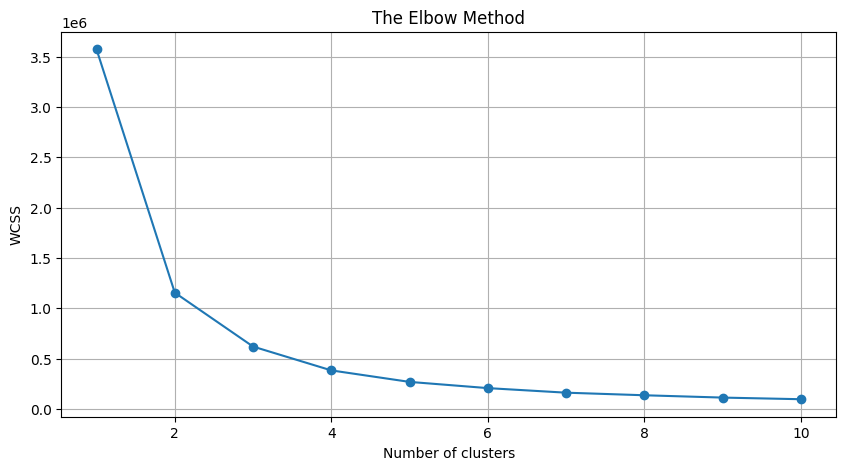

In [54]:
# Selecting a subset of features for clustering
features_for_clustering = ['Age', 'Rating', 'Recommended IND']
clustering_data = df[features_for_clustering]

# Using the Elbow Method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(clustering_data)
    wcss.append(kmeans.inertia_)

# Plotting the results of the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

From the plot, it appears that the elbow point could be around 3 or 4 clusters.

In [56]:
# Performing K-Means clustering with the selected number of clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(clustering_data)

# Adding the cluster labels to our dataset
df['Cluster'] = cluster_labels

# Displaying the first few rows with cluster labels
df[['Age', 'Rating', 'Recommended IND', 'Cluster']].head()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Age,Rating,Recommended IND,Cluster
0,33,4,1,0
1,34,5,1,3
2,60,3,0,2
3,50,5,1,1
4,47,5,1,1


### 1. Age Prediction ###


In [ ]:
X_age = df.drop(['Age', 'Rating', 'Cluster', 'Recommended IND'], axis=1)
y_age = df['Age']
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y_age, test_size=0.2, random_state=42)
regressor_age = LinearRegression()
regressor_age.fit(X_train_age, y_train_age)
y_pred_age = regressor_age.predict(X_test_age)
mse_age = mean_squared_error(y_test_age, y_pred_age)
r2_age = r2_score(y_test_age, y_pred_age)


### 2. Recommended IND Prediction ###

In [ ]:
X_rec = df.drop(['Age', 'Rating', 'Cluster', 'Recommended IND'], axis=1)
y_rec = df['Recommended IND']
X_train_rec, X_test_rec, y_train_rec, y_test_rec = train_test_split(X_rec, y_rec, test_size=0.2, random_state=42)
classifier_rec = LogisticRegression(max_iter=1000)
classifier_rec.fit(X_train_rec, y_train_rec)
y_pred_rec = classifier_rec.predict(X_test_rec)
accuracy_rec = accuracy_score(y_test_rec, y_pred_rec)
conf_matrix_rec = confusion_matrix(y_test_rec, y_pred_rec)


### 3. Rating Prediction ###

In [ ]:
X_rating = df.drop(['Age', 'Rating', 'Cluster', 'Recommended IND'], axis=1)
y_rating = df['Rating']
X_train_rat, X_test_rat, y_train_rat, y_test_rat = train_test_split(X_rating, y_rating, test_size=0.2, random_state=42)
classifier_rat = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_rat.fit(X_train_rat, y_train_rat)
y_pred_rat = classifier_rat.predict(X_test_rat)
accuracy_rat = accuracy_score(y_test_rat, y_pred_rat)
classification_report_rat = classification_report(y_test_rat, y_pred_rat)



## **Model Evaluation** ##

### 1. Age Prediction ###

In [ ]:
print("Age Prediction - MSE:", mse_age, "R2:", r2_age)

### 2. Recommended IND Prediction ###

In [ ]:
print("Recommended IND Prediction - Accuracy:", accuracy_rec, "Confusion Matrix:", conf_matrix_rec)

### 3. Rating Prediction ###

In [ ]:
print("Rating Prediction - Accuracy:", accuracy_rat, "Classification Report:", classification_report_rat)

## **Hyperparameter Tuning and Optimization** ##

### Grid Search ###

1. Logistic Regression

In [ ]:
# Setting up the hyperparameter grid
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']  # Depending on the size of your dataset
}

# Initialize the GridSearchCV object
grid_search_logistic = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logistic, cv=5, n_jobs=-1, verbose=1)

# Fit it to the data
grid_search_logistic.fit(X_rec, y_rec)  # Assuming X_rec and y_rec are your features and labels for Recommended IND

# Best parameters and best score
print("Best parameters for Logistic Regression:", grid_search_logistic.best_params_)
print("Best score:", grid_search_logistic.best_score_)


2. Random Forest

In [ ]:
# Setting up the hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize the GridSearchCV object
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1, verbose=1)

# Fit it to the data
grid_search_rf.fit(X_rating, y_rating)  # Assuming X_rating and y_rating are your features and labels for Rating

# Best parameters and best score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score:", grid_search_rf.best_score_)


### Bayesian Optimization ###

1. Logistic Regression

In [ ]:
# Function to optimize Logistic Regression
def logistic_optimize(C):
    classifier = LogisticRegression(C=C, max_iter=1000)
    score = cross_val_score(classifier, X_rec, y_rec, scoring='accuracy', cv=5)
    return np.mean(score)

# Bayesian Optimization for Logistic Regression
optimizer_logistic = BayesianOptimization(
    f=logistic_optimize,
    pbounds={'C': (0.001, 10)},
    random_state=42
)



# Maximizing the optimization functions
optimizer_logistic.maximize(init_points=5, n_iter=10)

# Best parameters found
best_params_logistic = optimizer_logistic.max['params']
print("Best parameters for Logistic Regression:", best_params_logistic)


2. Random Forest

In [ ]:
# Function to optimize Random Forest Classifier
def rf_optimize(n_estimators, max_depth, min_samples_split):
    classifier = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        random_state=42
    )
    score = cross_val_score(classifier, X_rating, y_rating, scoring='accuracy', cv=5)
    return np.mean(score)

# Bayesian Optimization for Random Forest Classifier
optimizer_rf = BayesianOptimization(
    f=rf_optimize,
    pbounds={
        'n_estimators': (10, 200),
        'max_depth': (5, 50),
        'min_samples_split': (2, 10)
    },
    random_state=42
)

# Maximizing the optimization functions
optimizer_rf.maximize(init_points=5, n_iter=10)

# Best parameters found
best_params_rf = optimizer_rf.max['params']
print("Best parameters for Random Forest Classifier:", best_params_rf)
